<a href="https://colab.research.google.com/github/SarinaJami/Rumor-Stance-Classification/blob/main/RSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import pandas as pd
from IPython.display import JSON

In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/downloads.gate.ac.uk/pheme/semeval2017-task8-dataset.tar.bz2

--2022-07-11 05:29:55--  https://s3-eu-west-1.amazonaws.com/downloads.gate.ac.uk/pheme/semeval2017-task8-dataset.tar.bz2
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.56.187
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.56.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4324141 (4.1M) [application/x-bzip2]
Saving to: ‘semeval2017-task8-dataset.tar.bz2.1’

semeval2017-task8-d 100%[===================>]   4.12M  5.59MB/s    in 0.7s    

2022-07-11 05:29:56 (5.59 MB/s) - ‘semeval2017-task8-dataset.tar.bz2.1’ saved [4324141/4324141]



In [ ]:
!tar -xf semeval2017-task8-dataset.tar.bz2

In [ ]:
dataset_dir="./semeval2017-task8-dataset"

In [ ]:
def load_tweet(tweet_path,source_id):
    tweets_info=[]
    source_json=tweet_path+"/source-tweet/"+source_id+".json"
    with open(source_json,'r') as f:
        info=json.load(f)
        tweets_info.append({
            "tweet_id":source_id,
            "text":info['text'],
            "source":None
        })
    reply_ids=os.listdir(tweet_path+"/replies")
    for reply_id in reply_ids:
        if 'json' not in reply_id:
            continue
        reply_id=reply_id.split('.')[0]
        reply_json=tweet_path+"/replies/"+reply_id+".json"
        with open(reply_json,'r') as f:
            info=json.load(f)
            tweets_info.append({
                "tweet_id":reply_id,
                "text":info['text'],
                "source":source_id
            })
    return tweets_info
def load_event(event_name):
    tweets=[]
    event_dir=f'{dataset_dir}/rumoureval-data/{event_name}'
    sources_id=os.listdir(event_dir)
    ignores=['.DS_Store']
    sources_id=[sid for sid in  sources_id if sid not in ignores]
    for source_id in sources_id:
        source_json_dir=f'{event_dir}/{source_id}'
        tweets.extend(load_tweet(source_json_dir,source_id))
    return tweets

def get_event_names():
    events_dir=f'{dataset_dir}/rumoureval-data/'
    sources=os.listdir(events_dir)
    ignores=['.DS_Store']
    sources=[source for source in sources if source not in ignores]
    return sources
def load_labels():
    with open('./semeval2017-task8-dataset/traindev/rumoureval-subtaskA-train.json','r') as f:
        tweet_label=json.load(f)
    tweet_label=[{'tweet_id':i,'label':val}for i,val in tweet_label.items()]
    tweet_label_train=pd.DataFrame(tweet_label)
    tweet_label_train.set_index('tweet_id',drop=True,inplace=True)
    tweet_label_train['label_type']='train'
    
    
    with open('./semeval2017-task8-dataset/traindev/rumoureval-subtaskA-dev.json','r') as f:
        tweet_label=json.load(f)
    tweet_label=[{'tweet_id':i,'label':val}for i,val in tweet_label.items()]
    tweet_label_dev=pd.DataFrame(tweet_label)
    tweet_label_dev.set_index('tweet_id',drop=True,inplace=True)
    tweet_label_dev['label_type']='dev'
    
    tweet_label=pd.concat([tweet_label_dev,tweet_label_train])
    return tweet_label
def load_dataset():
    tweets_info=[]
    events=get_event_names()
    for event in events:
        tweets_info.extend(load_event(event))
    tweet_df=pd.DataFrame(tweets_info)
    tweet_df.set_index('tweet_id',drop=True,inplace=True)
    
    tweet_labels=load_labels()
    tweet_df['label']=tweet_labels['label']
    tweet_df['label_type']=tweet_labels['label_type']
    return tweet_df
    
df=load_dataset()

In [ ]:
df.head()

,text,source,label,label_type
tweet_id,,,,
544288681021145090,Up to 20 held hostage in Sydney Lindt Cafe sie...,None,support,train
544290348525449216,“@Independent: Up to 20 held hostage in Sydney...,544288681021145090,support,train
544290635013189632,@Independent @Hragy oh god !!!!,544288681021145090,comment,train
544288801926156289,“@Independent: Up to 20 held hostage in Sydney...,544288681021145090,support,train
544297324466282497,@Independent Can we take the gloves off and go...,544288681021145090,comment,train


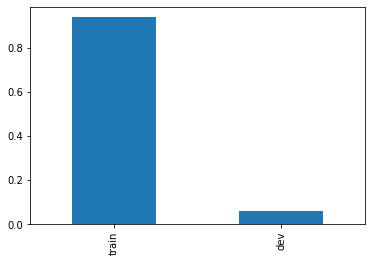

In [ ]:
(df.label_type.value_counts()/df.shape[0]).plot(kind='bar')

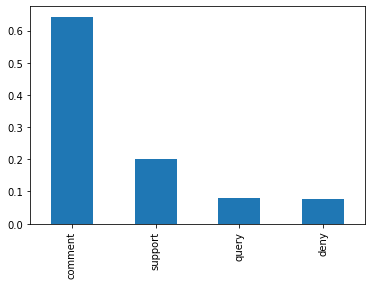

In [ ]:
(df.label.value_counts()/df.shape[0]).plot(kind='bar')

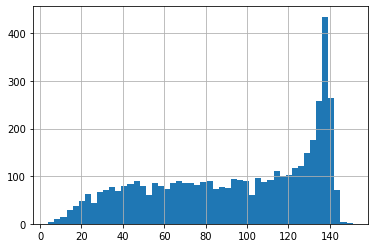

In [ ]:
df.text.str.len().hist(bins=50)

In [ ]:
max_len=df.text.str.len().max()
max_len

151

In [ ]:
df.label_type.value_counts()/df.shape[0]

train    0.937818
dev      0.062182
Name: label_type, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.label)
df['label_i'] = le.transform(df.label)

In [ ]:
df.head()

,text,source,label,label_type,label_i
tweet_id,,,,,
544288681021145090,Up to 20 held hostage in Sydney Lindt Cafe sie...,None,support,train,3
544290348525449216,“@Independent: Up to 20 held hostage in Sydney...,544288681021145090,support,train,3
544290635013189632,@Independent @Hragy oh god !!!!,544288681021145090,comment,train,0
544288801926156289,“@Independent: Up to 20 held hostage in Sydney...,544288681021145090,support,train,3
544297324466282497,@Independent Can we take the gloves off and go...,544288681021145090,comment,train,0


In [ ]:
df['data_type']=''
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['label', 'data_type']).agg(label_count=('label_i','count'))

label_count
label   data_type             
comment train             2471
        val                436
deny    train              292
        val                 52
query   train              304
        val                 54
support train              774
        val                136

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [ ]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = max_len,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = max_len,
                                                return_tensors = 'pt')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import torch

In [ ]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label_i.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label_i.values)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(le.classes_),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32 # mini-batch gradient decent

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
device = torch.device("cuda")
model = model.to(device)

In [ ]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'macro')

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def acc_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
!mkdir Models

mkdir: cannot create directory ‘Models’: File exists


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
            outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        #progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'Models/ BERT_ft_epoch{epoch}.model')
    
    tqdm.write(f'\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    #tqdm.write(f'Training loss: {loss_train_ave}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = acc_score_func(predictions, true_vals)
    #tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (macro): {val_f1}')
    tqdm.write(f'ACC Score: {val_acc}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 1


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.327561669829222
ACC Score: 0.7020648967551623


Epoch 2:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 2


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.4761320799846919
ACC Score: 0.7227138643067846


Epoch 3:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 3


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.4744329540910909
ACC Score: 0.724188790560472


Epoch 4:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 4


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.4805490628953327
ACC Score: 0.7064896755162242


Epoch 5:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 5


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.4738728936502623
ACC Score: 0.6976401179941003


Epoch 6:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 6


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.4820602625438257
ACC Score: 0.7064896755162242


Epoch 7:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 7


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.48803513923372244
ACC Score: 0.7153392330383481


Epoch 8:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 8


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.4823122803978631
ACC Score: 0.7079646017699115


Epoch 9:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 9


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.47769213410852407
ACC Score: 0.7035398230088495


Epoch 10:   0%|          | 0/121 [00:00<?, ?it/s]


 Epoch 10


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score (macro): 0.49122450280469154
ACC Score: 0.7064896755162242
